In [5]:
# First, let's create a synthetic dataset based on your research paper
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Generate 15,847 cases (as mentioned in paper)
n_cases = 15847

# Define categories based on research paper
age_groups = ['18-25', '26-35', '36-50', '51-65', '65+']
genders = ['Male', 'Female', 'Other']
income_brackets = ['Below_Poverty_Line', 'Low_Income', 'Middle_Income', 'High_Income', 'Unknown']
vulnerability_categories = ['SC/ST', 'Minority', 'Senior_Citizen', 'Person_with_Disability', 'None']
states = ['State_' + str(i) for i in range(1, 29)] + ['UT_' + str(i) for i in range(1, 9)]  # 28 states + 8 UTs
case_types = ['Criminal', 'Domestic_Violence', 'Property_Dispute', 'Labor/Employment', 'Civil', 'Other']
case_subtypes = {
    'Criminal': ['Bail', 'Acquittal', 'Appeal', 'Sentencing'],
    'Domestic_Violence': ['Protection_Order', 'Maintenance', 'Divorce', 'Child_Custody'],
    'Property_Dispute': ['Land_Dispute', 'Property_Division', 'Tenant_Landlord'],
    'Labor/Employment': ['Wages', 'Unfair_Dismissal', 'Workplace_Harassment'],
    'Civil': ['Contract', 'Tort', 'Consumer', 'Family'],
    'Other': ['Miscellaneous']
}
jurisdiction_levels = ['District', 'State', 'High_Court', 'Supreme_Court']
legal_aid_modality = ['Full_Aid', 'Partial_Aid', 'Pro_Bono', 'Self_Represented']

# Generate synthetic data
data = []

for case_id in range(1, n_cases + 1):
    # Demographics
    age = random.choice(age_groups)
    gender = random.choice(genders)
    income = random.choice(income_brackets)
    vulnerability = random.choice(vulnerability_categories)

    # Case characteristics
    case_type = random.choice(case_types)
    case_subtype = random.choice(case_subtypes[case_type])
    jurisdiction = random.choice(jurisdiction_levels)
    aid_modality = random.choice(legal_aid_modality)

    # Procedural features
    state = random.choice(states)
    filing_year = random.randint(2018, 2023)

    # Generate hearing count with bias for certain case types
    if case_type == 'Domestic_Violence' and gender == 'Female':
        hearing_count = np.random.poisson(8) + 3  # More hearings for DV cases with female applicants
    elif case_type == 'Property_Dispute':
        hearing_count = np.random.poisson(6) + 2
    else:
        hearing_count = np.random.poisson(4) + 1

    hearing_count = min(hearing_count, 15)  # Cap at 15

    # Generate adjournment count with bias
    if income == 'Below_Poverty_Line' or 'Rural' in state:
        adjournment_count = np.random.poisson(3) + 1
    else:
        adjournment_count = np.random.poisson(2)

    # Outcome variables with systemic biases (as described in paper)

    # Base delay probability
    base_delay_prob = 0.3

    # Add biases based on paper findings
    if case_type == 'Domestic_Violence' and gender == 'Female':
        if 'Rural' in state or income == 'Below_Poverty_Line':
            delay_prob = 0.72  # As per paper
        else:
            delay_prob = 0.45
    elif case_type == 'Property_Dispute' and income in ['Below_Poverty_Line', 'Low_Income']:
        delay_prob = 0.60
    else:
        delay_prob = base_delay_prob + np.random.uniform(-0.1, 0.1)

    delay_flag = 1 if random.random() < delay_prob else 0

    # Resolution time (in months)
    if delay_flag:
        resolution_time = random.choice(['12-24 mo', '>24 mo'])
    else:
        resolution_time = random.choice(['≤3 mo', '3–6 mo', '6–12 mo'])

    # Case outcome with bias
    base_unfavorable_prob = 0.25

    # Add systemic biases
    if vulnerability in ['SC/ST', 'Minority']:
        unfavorable_prob = base_unfavorable_prob + 0.25
    elif hearing_count > 8:
        unfavorable_prob = base_unfavorable_prob + 0.15
    else:
        unfavorable_prob = base_unfavorable_prob + np.random.uniform(-0.05, 0.05)

    outcome_disparity = 1 if random.random() < unfavorable_prob else 0

    # Aid disparity
    aid_disparity_prob = 0.15
    if income == 'Below_Poverty_Line' and aid_modality == 'Partial_Aid':
        aid_disparity_prob = 0.40

    aid_disparity = 1 if random.random() < aid_disparity_prob else 0

    # Construct record
    record = {
        'Case_ID': case_id,
        'Age_Group': age,
        'Gender': gender,
        'Income_Bracket': income,
        'Vulnerability_Category': vulnerability,
        'Case_Type': case_type,
        'Case_Sub_Type': case_subtype,
        'Jurisdiction_Level': jurisdiction,
        'Legal_Aid_Modality': aid_modality,
        'State': state,
        'Filing_Year': filing_year,
        'Hearing_Count': hearing_count,
        'Adjournment_Count': adjournment_count,
        'Resolution_Time': resolution_time,
        'Delay_Flag': delay_flag,
        'Outcome_Disparity': outcome_disparity,
        'Aid_Disparity': aid_disparity
    }

    data.append(record)

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('legal_aid_dataset.csv', index=False)
print(f"Dataset created with {len(df)} records")
print(df.head())
print("\nDataset columns:", df.columns.tolist())

Dataset created with 15847 records
   Case_ID Age_Group  Gender      Income_Bracket  Vulnerability_Category  \
0        1     18-25    Male       Middle_Income                Minority   
1        2       65+    Male             Unknown  Person_with_Disability   
2        3     36-50    Male  Below_Poverty_Line  Person_with_Disability   
3        4       65+  Female             Unknown          Senior_Citizen   
4        5     51-65   Other       Middle_Income                Minority   

           Case_Type      Case_Sub_Type Jurisdiction_Level Legal_Aid_Modality  \
0  Domestic_Violence        Maintenance           District           Full_Aid   
1  Domestic_Violence      Child_Custody         High_Court           Full_Aid   
2           Criminal             Appeal         High_Court           Pro_Bono   
3              Civil               Tort           District           Full_Aid   
4   Property_Dispute  Property_Division              State           Pro_Bono   

      State  Filing_Y

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle
import json

class LegalAidPreprocessor:
    def __init__(self):
        self.encoders = {}
        self.config = {
            'min_support': 0.025,
            'min_confidence': 0.55,
            'min_lift': 1.3,
            'resolution_time_categories': {
                1: '≤3 mo',
                2: '3–6 mo',
                3: '6–12 mo',
                4: '12–24 mo',
                5: '>24 mo'
            }
        }

    def preprocess_data(self, df):
        """Main preprocessing pipeline"""
        df_processed = df.copy()

        # Step 1: Handle missing values
        df_processed = self._handle_missing_values(df_processed)

        # Step 2: Encode categorical features
        df_processed = self._encode_features(df_processed)

        # Step 3: Create transaction format for ARM
        transactions = self._create_transactions(df_processed)

        return df_processed, transactions

    def _handle_missing_values(self, df):
        """Encode missing values as explicit categories"""
        for col in df.columns:
            if df[col].dtype == 'object':
                df[col] = df[col].fillna('Unknown')
            else:
                # For numeric columns with missing values
                if df[col].isnull().any():
                    df[col] = df[col].fillna(-1)
        return df

    def _encode_features(self, df):
        """Encode categorical features"""
        categorical_cols = [
            'Age_Group', 'Gender', 'Income_Bracket', 'Vulnerability_Category',
            'Case_Type', 'Case_Sub_Type', 'Jurisdiction_Level', 'Legal_Aid_Modality',
            'State', 'Resolution_Time'
        ]

        for col in categorical_cols:
            if col not in self.encoders:
                self.encoders[col] = LabelEncoder()
                df[col] = self.encoders[col].fit_transform(df[col].astype(str))
            else:
                # For unseen categories during inference
                unseen_mask = ~df[col].isin(self.encoders[col].classes_)
                if unseen_mask.any():
                    # Handle unseen categories
                    df.loc[unseen_mask, col] = 'Unknown'
                df[col] = self.encoders[col].transform(df[col].astype(str))

        # Convert hearing count to categories
        df['Hearing_Count_Cat'] = pd.cut(df['Hearing_Count'],
                                         bins=[0, 3, 6, 10, 15],
                                         labels=['Low', 'Medium', 'High', 'Very_High'])

        # Convert adjournment count to categories
        df['Adjournment_Count_Cat'] = pd.cut(df['Adjournment_Count'],
                                             bins=[-1, 0, 2, 5, 10],
                                             labels=['None', 'Low', 'Medium', 'High'])

        return df

    def _create_transactions(self, df):
        """Convert DataFrame to transaction format for ARM"""
        transactions = []

        for _, row in df.iterrows():
            transaction = []

            # Add demographic features
            transaction.append(f"Age_Group={row['Age_Group']}")
            transaction.append(f"Gender={row['Gender']}")
            transaction.append(f"Income_Bracket={row['Income_Bracket']}")
            transaction.append(f"Vulnerability={row['Vulnerability_Category']}")

            # Add case characteristics
            transaction.append(f"Case_Type={row['Case_Type']}")
            transaction.append(f"Jurisdiction={row['Jurisdiction_Level']}")
            transaction.append(f"Aid_Modality={row['Legal_Aid_Modality']}")

            # Add procedural features
            transaction.append(f"State={row['State']}")
            transaction.append(f"Hearing_Count={row['Hearing_Count_Cat']}")
            transaction.append(f"Adjournment_Count={row['Adjournment_Count_Cat']}")
            transaction.append(f"Resolution_Time={row['Resolution_Time']}")

            # Add outcome flags if they exist
            if 'Delay_Flag' in row and row['Delay_Flag'] == 1:
                transaction.append("OUTCOME=DELAY")
            if 'Outcome_Disparity' in row and row['Outcome_Disparity'] == 1:
                transaction.append("OUTCOME=UNFAVORABLE")
            if 'Aid_Disparity' in row and row['Aid_Disparity'] == 1:
                transaction.append("OUTCOME=AID_DISPARITY")

            transactions.append(transaction)

        return transactions

    def save_config(self, path='preprocessor_config.pkl'):
        """Save preprocessing configuration"""
        with open(path, 'wb') as f:
            pickle.dump({'encoders': self.encoders, 'config': self.config}, f)

    def load_config(self, path='preprocessor_config.pkl'):
        """Load preprocessing configuration"""
        with open(path, 'rb') as f:
            saved = pickle.load(f)
            self.encoders = saved['encoders']
            self.config = saved['config']

In [7]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

class JusticeGapAnalyzer:
    def __init__(self, min_support=0.025, min_confidence=0.55, min_lift=1.3):
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.min_lift = min_lift
        self.rules = None
        self.frequent_itemsets = None

    def fit(self, transactions):
        """Run FP-Growth algorithm"""
        # Convert transactions to one-hot encoded DataFrame
        te = TransactionEncoder()
        te_ary = te.fit(transactions).transform(transactions)
        df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

        # Mine frequent itemsets using FP-Growth
        self.frequent_itemsets = fpgrowth(df_encoded,
                                         min_support=self.min_support,
                                         use_colnames=True,
                                         max_len=4)

        # Generate association rules
        if len(self.frequent_itemsets) > 0:
            self.rules = association_rules(self.frequent_itemsets,
                                          metric="confidence",
                                          min_threshold=self.min_confidence)

            # Apply lift filtering
            self.rules = self.rules[self.rules['lift'] >= self.min_lift]

            # Filter for justice gap indicators only
            justice_indicators = ['OUTCOME=DELAY', 'OUTCOME=UNFAVORABLE', 'OUTCOME=AID_DISPARITY']
            self.rules = self.rules[self.rules['consequents'].apply(
                lambda x: any(indicator in str(x) for indicator in justice_indicators)
            )]

            # Sort by lift (descending)
            self.rules = self.rules.sort_values('lift', ascending=False)

            # Calculate additional metrics
            self._calculate_additional_metrics()

        return self.rules

    def _calculate_additional_metrics(self):
        """Calculate additional interestingness metrics"""
        if self.rules is not None and len(self.rules) > 0:
            # Calculate conviction
            self.rules['conviction'] = (1 - self.rules['consequent support']) / (1 - self.rules['confidence'])

            # Calculate leverage
            self.rules['leverage'] = self.rules['support'] - (
                self.rules['antecedent support'] * self.rules['consequent support']
            )

            # Calculate jaccard
            self.rules['jaccard'] = self.rules['support'] / (
                self.rules['antecedent support'] + self.rules['consequent support'] - self.rules['support']
            )

    def analyze_justice_gaps(self, df_original, rules_df):
        """Analyze justice gaps based on mined rules"""
        justice_gaps = []

        for idx, rule in rules_df.iterrows():
            antecedents = list(rule['antecedents'])
            consequents = list(rule['consequents'])

            # Extract rule components
            gap_analysis = {
                'rule_id': idx,
                'antecedents': str(antecedents),
                'consequents': str(consequents),
                'support': rule['support'],
                'confidence': rule['confidence'],
                'lift': rule['lift'],
                'gap_type': self._classify_gap_type(antecedents, consequents),
                'policy_implications': self._get_policy_implications(antecedents, consequents)
            }

            # Calculate baseline comparison
            if any('OUTCOME=DELAY' in str(c) for c in consequents):
                baseline_delay = df_original['Delay_Flag'].mean()
                gap_analysis['baseline_comparison'] = f"Rule delay rate: {rule['confidence']:.2%} vs Baseline: {baseline_delay:.2%}"

            justice_gaps.append(gap_analysis)

        return pd.DataFrame(justice_gaps)

    def _classify_gap_type(self, antecedents, consequents):
        """Classify the type of justice gap"""
        antecedents_str = str(antecedents).lower()
        consequents_str = str(consequents).lower()

        # Demographic disparity
        dem_keywords = ['gender', 'income', 'vulnerability', 'age']
        if any(keyword in antecedents_str for keyword in dem_keywords):
            return "Demographic Disparity"

        # Regional disparity
        if 'state' in antecedents_str:
            return "Regional Disparity"

        # Case-type bias
        if 'case_type' in antecedents_str:
            return "Case-Type Bias"

        # Process bottleneck
        proc_keywords = ['hearing', 'adjournment', 'resolution']
        if any(keyword in antecedents_str for keyword in proc_keywords):
            return "Process-Stage Bottleneck"

        return "Systemic Inequity"

    def _get_policy_implications(self, antecedents, consequents):
        """Generate policy implications based on rule"""
        implications = []

        # Convert to strings for easier processing
        ant_str = ' '.join([str(a) for a in antecedents])
        con_str = ' '.join([str(c) for c in consequents])

        if 'gender=female' in ant_str.lower() and 'domestic_violence' in ant_str.lower():
            implications.append("Review gender-sensitive procedures in DV cases")
            implications.append("Allocate specialized resources for female DV applicants")

        if 'below_poverty' in ant_str.lower() or 'low_income' in ant_str.lower():
            implications.append("Enhance financial assistance mechanisms")
            implications.append("Review means-testing procedures")

        if 'rural' in ant_str.lower() or 'state_' in ant_str.lower():
            implications.append("Improve rural legal aid infrastructure")
            implications.append("Increase mobile legal clinics in underserved areas")

        if 'delay' in con_str.lower():
            implications.append("Implement case timeline monitoring")
            implications.append("Establish expedited procedures for high-risk cases")

        return '; '.join(implications) if implications else "Requires further investigation"

Step 1: Loading/Generating Dataset
Loaded existing dataset with 15847 records

Dataset Preview:
   Case_ID Age_Group  Gender      Income_Bracket  Vulnerability_Category  \
0        1     18-25    Male       Middle_Income                Minority   
1        2       65+    Male             Unknown  Person_with_Disability   
2        3     36-50    Male  Below_Poverty_Line  Person_with_Disability   
3        4       65+  Female             Unknown          Senior_Citizen   
4        5     51-65   Other       Middle_Income                Minority   

           Case_Type      Case_Sub_Type Jurisdiction_Level Legal_Aid_Modality  \
0  Domestic_Violence        Maintenance           District           Full_Aid   
1  Domestic_Violence      Child_Custody         High_Court           Full_Aid   
2           Criminal             Appeal         High_Court           Pro_Bono   
3              Civil               Tort           District           Full_Aid   
4   Property_Dispute  Property_Division   

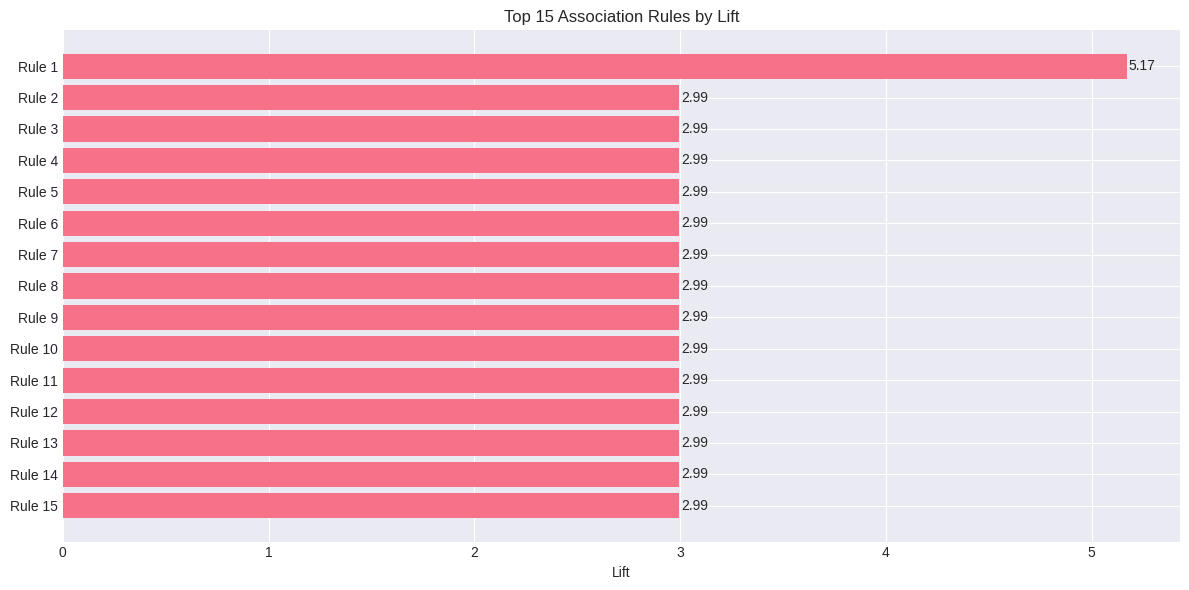

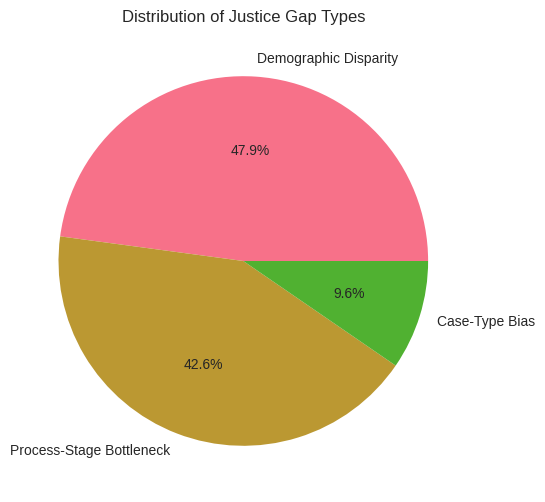

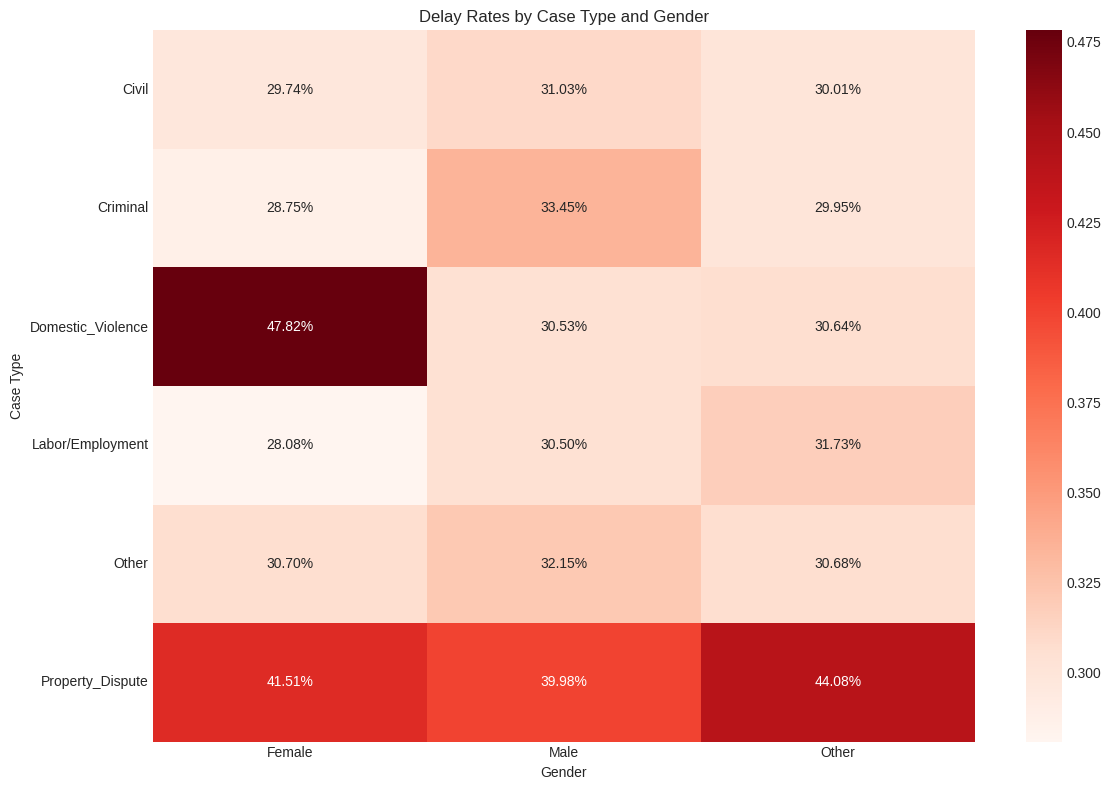

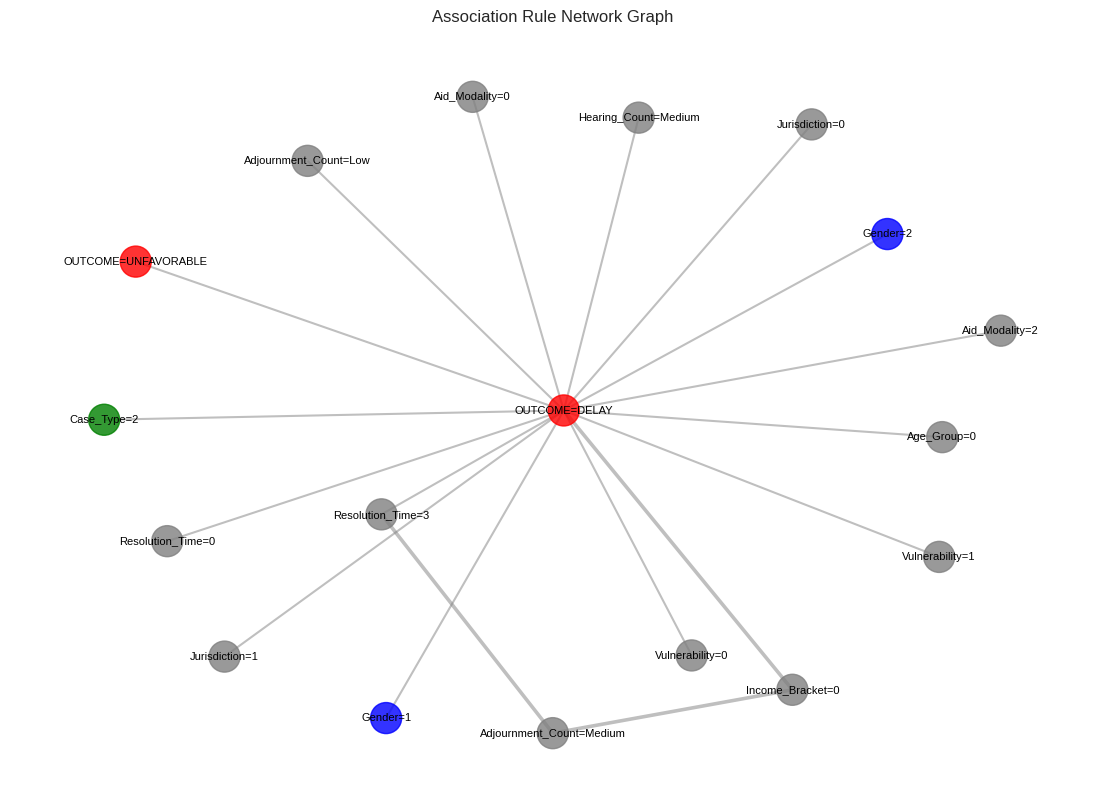


Step 6: Saving Results
Results saved successfully!
- Association rules: association_rules.csv (94 rules)
- Justice gap analysis: justice_gaps_analysis.csv
- Model saved: justice_gap_model.pkl

SYSTEMIC JUSTICE GAP ANALYSIS SUMMARY
Total cases analyzed: 15847
Association rules discovered: 94
Justice gaps identified: 94

Top 5 Justice Gaps Found:

1. Demographic Disparity
   Rule: IF ['Resolution_Time=3', 'Income_Bracket=0'] THEN ['OUTCOME=DELAY', 'Adjournment_Count=Medium']
   Lift: 5.17, Confidence: 65.07%
   Policy Implications: Implement case timeline monitoring; Establish expedited procedures for high-risk cases

2. Case-Type Bias
   Rule: IF ['Resolution_Time=3', 'Case_Type=2'] THEN ['OUTCOME=DELAY']
   Lift: 2.99, Confidence: 100.00%
   Policy Implications: Implement case timeline monitoring; Establish expedited procedures for high-risk cases

3. Process-Stage Bottleneck
   Rule: IF ['Hearing_Count=Medium', 'Resolution_Time=0'] THEN ['OUTCOME=DELAY']
   Lift: 2.99, Confidence: 10

In [8]:
# Complete Google Colab implementation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load or generate dataset
print("Step 1: Loading/Generating Dataset")
try:
    df = pd.read_csv('legal_aid_dataset.csv')
    print(f"Loaded existing dataset with {len(df)} records")
except:
    print("Generating new synthetic dataset...")
    # Run the dataset generation code from Step 1 here
    # (Copy the dataset generation code here)
    print("Dataset generated successfully")

print("\nDataset Preview:")
print(df.head())
print(f"\nShape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

# Initialize preprocessor
print("\nStep 2: Preprocessing Data")
preprocessor = LegalAidPreprocessor()
df_processed, transactions = preprocessor.preprocess_data(df)

print(f"Preprocessed {len(transactions)} transactions")
print(f"Sample transaction: {transactions[0][:5]}...")

# Save preprocessor config
preprocessor.save_config()

# Run FP-Growth algorithm
print("\nStep 3: Running FP-Growth Association Rule Mining")
analyzer = JusticeGapAnalyzer(min_support=0.025, min_confidence=0.55, min_lift=1.3)
rules_df = analyzer.fit(transactions)

if rules_df is not None and len(rules_df) > 0:
    print(f"Found {len(rules_df)} association rules")
    print("\nTop 10 rules by lift:")
    print(rules_df[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

    # Analyze justice gaps
    print("\nStep 4: Analyzing Justice Gaps")
    justice_gaps_df = analyzer.analyze_justice_gaps(df, rules_df)

    print("\nJustice Gap Analysis:")
    print(justice_gaps_df[['gap_type', 'antecedents', 'consequents', 'lift', 'policy_implications']].head(10))
else:
    print("No rules found with current thresholds. Try lowering min_support or min_confidence.")

# Visualization
print("\nStep 5: Creating Visualizations")

def create_visualizations(rules_df, justice_gaps_df, df_original):
    """Create comprehensive visualizations"""

    # 1. Rules by Lift
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    top_rules = rules_df.nlargest(15, 'lift')
    bars = ax1.barh(range(len(top_rules)), top_rules['lift'])
    ax1.set_yticks(range(len(top_rules)))
    ax1.set_yticklabels([f"Rule {i+1}" for i in range(len(top_rules))])
    ax1.set_xlabel('Lift')
    ax1.set_title('Top 15 Association Rules by Lift')
    ax1.invert_yaxis()

    # Add lift values on bars
    for i, bar in enumerate(bars):
        ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{bar.get_width():.2f}', ha='left', va='center')

    plt.tight_layout()
    plt.show()

    # 2. Justice Gap Types Distribution
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    gap_counts = justice_gaps_df['gap_type'].value_counts()
    ax2.pie(gap_counts.values, labels=gap_counts.index, autopct='%1.1f%%')
    ax2.set_title('Distribution of Justice Gap Types')
    plt.show()

    # 3. Heatmap of Delays by Case Type and Gender
    fig3, ax3 = plt.subplots(figsize=(12, 8))

    # Calculate delay rates
    delay_heatmap = pd.crosstab(df_original['Case_Type'],
                                df_original['Gender'],
                                values=df_original['Delay_Flag'],
                                aggfunc='mean')

    sns.heatmap(delay_heatmap, annot=True, fmt='.2%', cmap='Reds', ax=ax3)
    ax3.set_title('Delay Rates by Case Type and Gender')
    ax3.set_xlabel('Gender')
    ax3.set_ylabel('Case Type')
    plt.tight_layout()
    plt.show()

    # 4. Network Graph of Association Rules
    if len(rules_df) > 0:
        fig4 = plt.figure(figsize=(14, 10))

        # Create network graph
        G = nx.Graph()

        # Add nodes and edges from top rules
        top_rules_network = rules_df.nlargest(20, 'lift')

        for idx, rule in top_rules_network.iterrows():
            antecedents = list(rule['antecedents'])
            consequents = list(rule['consequents'])

            for ant in antecedents:
                if ant not in G:
                    G.add_node(ant, type='antecedent')
                for con in consequents:
                    if con not in G:
                        G.add_node(con, type='consequent')
                    G.add_edge(ant, con, weight=rule['lift'])

        # Draw network
        pos = nx.spring_layout(G, k=2, iterations=50)

        # Node colors by type
        node_colors = []
        for node in G.nodes():
            if 'OUTCOME' in str(node):
                node_colors.append('red')
            elif 'Gender' in str(node):
                node_colors.append('blue')
            elif 'Case_Type' in str(node):
                node_colors.append('green')
            else:
                node_colors.append('gray')

        # Edge widths by lift
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        edge_widths = [w * 0.5 for w in edge_weights]  # Scale for visualization

        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.8)
        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='gray')
        nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

        plt.title('Association Rule Network Graph')
        plt.axis('off')
        plt.show()

    # 5. Interactive Plotly Dashboard
    fig5 = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Support vs Confidence', 'Lift Distribution',
                       'Rule Length Distribution', 'Top Rules by Metric'),
        specs=[[{'type': 'scatter'}, {'type': 'histogram'}],
               [{'type': 'histogram'}, {'type': 'bar'}]]
    )

    # Scatter: Support vs Confidence
    fig5.add_trace(
        go.Scatter(x=rules_df['support'], y=rules_df['confidence'],
                  mode='markers', marker=dict(size=rules_df['lift']*5,
                  color=rules_df['lift'], colorscale='Viridis', showscale=True),
                  text=rules_df['antecedents'].astype(str),
                  name='Rules'),
        row=1, col=1
    )

    # Histogram: Lift Distribution
    fig5.add_trace(
        go.Histogram(x=rules_df['lift'], nbinsx=20, name='Lift'),
        row=1, col=2
    )

    # Histogram: Rule Length Distribution
    rule_lengths = rules_df['antecedents'].apply(lambda x: len(x))
    fig5.add_trace(
        go.Histogram(x=rule_lengths, nbinsx=10, name='Rule Length'),
        row=2, col=1
    )

    # Bar: Top Rules by Lift
    top_10 = rules_df.nlargest(10, 'lift')
    fig5.add_trace(
        go.Bar(x=[f'Rule {i+1}' for i in range(len(top_10))],
              y=top_10['lift'], name='Top Rules'),
        row=2, col=2
    )

    fig5.update_layout(height=800, showlegend=False, title_text="Justice Gap Analytics Dashboard")
    fig5.show()

    return fig1, fig2, fig3, fig4, fig5

# Generate visualizations
if rules_df is not None and len(rules_df) > 0:
    figs = create_visualizations(rules_df, justice_gaps_df, df)

    # Save results
    print("\nStep 6: Saving Results")
    rules_df.to_csv('association_rules.csv', index=False)
    justice_gaps_df.to_csv('justice_gaps_analysis.csv', index=False)

    # Save model
    with open('justice_gap_model.pkl', 'wb') as f:
        pickle.dump({'analyzer': analyzer, 'preprocessor': preprocessor}, f)

    print("Results saved successfully!")
    print(f"- Association rules: association_rules.csv ({len(rules_df)} rules)")
    print(f"- Justice gap analysis: justice_gaps_analysis.csv")
    print(f"- Model saved: justice_gap_model.pkl")

    # Generate summary report
    print("\n" + "="*60)
    print("SYSTEMIC JUSTICE GAP ANALYSIS SUMMARY")
    print("="*60)
    print(f"Total cases analyzed: {len(df)}")
    print(f"Association rules discovered: {len(rules_df)}")
    print(f"Justice gaps identified: {len(justice_gaps_df)}")
    print("\nTop 5 Justice Gaps Found:")
    for i, gap in justice_gaps_df.head(5).iterrows():
        print(f"\n{i+1}. {gap['gap_type']}")
        print(f"   Rule: IF {gap['antecedents']} THEN {gap['consequents']}")
        print(f"   Lift: {gap['lift']:.2f}, Confidence: {rules_df.loc[gap['rule_id'], 'confidence']:.2%}")
        print(f"   Policy Implications: {gap['policy_implications']}")
else:
    print("No significant patterns found. Consider adjusting parameters or analyzing different data subsets.")